In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import numpy as np
import time
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import re
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from functools import reduce

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Create Datasets

adapted from https://github.com/yjs1210/yelp-recommender/blob/main/yelp_rating_master_notebook.ipynb

In [7]:
# open input file: 


def create_df(data_path, stop):
  ifile = open(data_path) 

  # read the first 100k entries
  # set to -1 to process everything
  # stop = 500000
  # stop = 
  all_data = list()
  for i, line in enumerate(ifile):
      if i==stop:
          break    
      # convert the json on this line to a dict
      data = json.loads(line)
      # extract what we want
      # text = data['text']
      # stars = data['stars']
      # add to the data collected so far
      all_data.append(data)
  # create the DataFrame
  df = pd.DataFrame(all_data, columns=data.keys())
  # df.to_hdf('revie20ws.h5','reviews')

  ifile.close()
  return df

In [8]:
users_data_path = '/content/gdrive/My Drive/SML IW/yelp_dataset/yelp_academic_dataset_user.json'
business_data_path = '/content/gdrive/My Drive/SML IW/yelp_dataset/yelp_academic_dataset_business.json'
reviews_data_path = '/content/gdrive/My Drive/SML IW/yelp_dataset/yelp_academic_dataset_review.json'

In [9]:
business = create_df(business_data_path, -1)
business.head(5)
print(len(business))

150346


In [10]:
users = create_df(users_data_path, -1)
print(users.head(5))
print(len(users))

                  user_id    name  review_count        yelping_since  useful  \
0  qVc8ODYU5SZjKXVBgXdI7w  Walker           585  2007-01-25 16:47:26    7217   
1  j14WgRoU_-2ZE1aw1dXrJg  Daniel          4333  2009-01-25 04:35:42   43091   
2  2WnXYQFK0hXEoTxPtV2zvg   Steph           665  2008-07-25 10:41:00    2086   
3  SZDeASXq7o05mMNLshsdIA    Gwen           224  2005-11-29 04:38:33     512   
4  hA5lMy-EnncsH4JoR-hFGQ   Karen            79  2007-01-05 19:40:59      29   

   funny   cool                                              elite  \
0   1259   5994                                               2007   
1  13066  27281  2009,2010,2011,2012,2013,2014,2015,2016,2017,2...   
2   1010   1003                           2009,2010,2011,2012,2013   
3    330    299                                     2009,2010,2011   
4     15      7                                                      

                                             friends  fans  ...  \
0  NSCy54eWehBJyZdG2iE84w, pe42

In [13]:
print(len(users))

1987897


In [11]:
reviews = create_df(reviews_data_path, 2000000)
reviews.head(5)
print(len(reviews))

2000000


In [12]:
n_users = len(reviews.user_id.unique())
n_restaurants = len(reviews.business_id.unique())
print('Unique Users: {0}, unique restaurants: {1}'.format(n_users, n_restaurants))

Unique Users: 895930, unique restaurants: 45055


In [13]:
business = business.dropna()
print(len(business))
print(len(business))
business = business[business.categories.str.contains("Restaurants" or "Food")]
print(len(business))
unique_r = business.business_id.unique()
reviews = reviews[reviews['business_id'].isin(unique_r)]
reviews.head(5)

117618
117618
44676


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16


In [14]:
# hold out last review
# https://github.com/yjs1210/yelp-recommender
reviews = pd.DataFrame(
    {"user_id": reviews['user_id'], "business_id": reviews['business_id'], "rating": reviews['stars'], "date": reviews['date'], "text": reviews['text']}
)
ratings_user_date = reviews.loc[:, ['user_id', 'date']]
ratings_user_date.date = pd.to_datetime(ratings_user_date.date)
index_holdout = ratings_user_date.groupby(['user_id'], sort=False)['date'].transform(max) == ratings_user_date['date']
ratings_holdout_ = reviews[index_holdout]
ratings_traincv_ = reviews[~index_holdout]

ratings_user_date = ratings_traincv_.loc[:, ['user_id', 'date']]
index_holdout = ratings_user_date.groupby(['user_id'], sort=False)['date'].transform(max) == ratings_user_date['date']
ratings_cv_ = ratings_traincv_[index_holdout]
ratings_train_ = ratings_traincv_[~index_holdout]

# remove the user that has fake reviews 

cv_users_del = set(ratings_cv_.user_id) - set(ratings_train_.user_id)
holdout_users_del = set(ratings_holdout_.user_id) - set(ratings_train_.user_id)
ratings_cv_ = ratings_cv_[~ratings_cv_.user_id.isin(cv_users_del)]
ratings_holdout_ = ratings_holdout_[~ratings_holdout_.user_id.isin(holdout_users_del)]

# ratings_cv_ = ratings_cv_[~ratings_cv_.user_id.isin(['HiT9sg9pvDiEVMFHJYihXg'])]
# ratings_holdout_ = ratings_holdout_[~ratings_holdout_.user_id.isin(['HiT9sg9pvDiEVMFHJYihXg'])]

print('There are {0} rows, {1} columns in training set.'.format(ratings_train_.shape[0], ratings_train_.shape[1]))
print('There are {0} rows, {1} columns in training set.'.format(ratings_cv_.shape[0], ratings_cv_.shape[1]))
print('There are {0} rows, {1} columns in holdout set.'.format(ratings_holdout_.shape[0], ratings_holdout_.shape[1]))

There are 484730 rows, 5 columns in training set.
There are 103332 rows, 5 columns in training set.
There are 103329 rows, 5 columns in holdout set.


In [12]:
business_nona = business.dropna()
print(len(business))
print(len(business_nona))
business_r = business_nona[business_nona.categories.str.contains("Restaurants" or "Food")]
print(len(business_r))
unique_r = business_r.business_id.unique()
r_reviews = reviews[reviews['business_id'].isin(unique_r)]
r_reviews.head(5)

44676
44676
44676


,user_id,business_id,rating,date,text
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is..."
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,2015-01-04 00:01:03,"Wow! Yummy, different, delicious. Our favo..."
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,2017-01-14 20:54:15,Cute interior and owner (?) gave us tour of up...
5,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,2015-09-23 23:10:31,I am a long term frequent customer of this est...
7,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2015-08-07 02:29:16,Amazingly amazing wings and homemade bleu chee...


# Data Analysis
adapted from: https://www.jillcates.com/pydata-workshop/html/tutorial.html#Step-5:-Item-item-Recommendations-with-k-Nearest-Neighbors

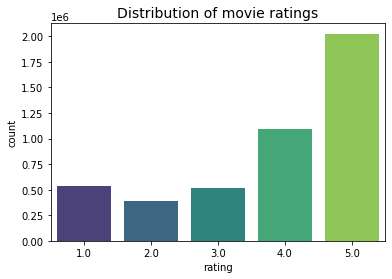

In [14]:
sns.countplot(x="rating", data=reviews, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [15]:
print(f"Mean global rating: {round(reviews['rating'].mean(),2)}.")

mean_ratings = reviews.groupby('user_id')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.81.
Mean rating per user: 3.74.


In [16]:
mean_ratings = reviews.groupby('business_id')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
business[business['business_id'] == lowest_rated]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
4811,-7Rx5jVeQmlVoAU_oXrzew,McDonald's,24 W Marlton Pike,Cherry Hill,NJ,08034,39.914764,-75.012779,1.0,11,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Burgers, Fast Food, Restaurants, Food, Coffee ...","{'Monday': '5:30-0:0', 'Tuesday': '5:30-0:0', ..."


In [17]:
highest_rated = mean_ratings['rating'].idxmax()
business[business['business_id'] == highest_rated]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
136158,--qLiYw2ErSmvVwumb2kdw,C.C.'s Kitchen,517 Station Ave,Haddon Heights,NJ,08035,39.882963,-75.058035,5.0,5,0,"{'BusinessParking': '{'garage': False, 'street...","Food, Restaurants, Soup, Desserts, American (N...","{'Monday': '21:0-0:0', 'Wednesday': '17:0-21:0..."


In [18]:
n_ratings = len(reviews)
n_businesses = reviews['business_id'].nunique()
n_users = reviews['user_id'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique businesses's: {n_businesses}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_businesses, 2)}")

Number of ratings: 4557625
Number of unique businesses's: 44676
Number of unique users: 1416823
Average number of ratings per user: 3.22
Average number of ratings per movie: 102.02


## Bayesian Average

In [19]:
business_stats = reviews.groupby('business_id')[['rating']].agg(['count', 'mean'])
business_stats.columns = business_stats.columns.droplevel()

In [20]:
C = business_stats['count'].mean()
m = business_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = reviews.groupby('business_id')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['business_id', 'bayesian_avg']
business_stats = business_stats.merge(bayesian_avg_ratings, on='business_id')

In [21]:
business_stats = business_stats.merge(business[['business_id', 'name']], on='business_id')
print(business_stats.head(5))
business_stats.sort_values('bayesian_avg', ascending=False).head()

              business_id  count      mean  bayesian_avg  \
0  ---kPU91CF4Lq2-WlRu9Lw     24  4.500000      3.725683   
1  --8IbOsAAxjKRoYsBFL-PA     27  2.925926      3.414269   
2  --ZVrH2X2QXBFdCilbirsw     36  4.722222      3.850972   
3  --epgcb7xHGuJ-4PUeSLAw     38  2.868421      3.360297   
4  --hF_3v1JmU9nlu4zfXJ8Q     15  4.733333      3.696038   

                                      name  
0                        Frankie's Raw Bar  
1                 The Original Italian Pie  
2                    Chris's Sandwich Shop  
3                          Manhattan Bagel  
4  Green District Salads - Monument Circle  


,business_id,count,mean,bayesian_avg,name
10223,DVBJRvnCpkqaYl6nHroaMg,724,4.853591,4.691794,Tumerico
26268,_aKr7POnacW_VizRKBpCiA,1027,4.788705,4.676193,Blues City Deli
6756,8QqnRpM-QxGsjDNuu0E57A,830,4.809639,4.671053,Carlillos Cocina
31053,gP_oWJykA2RocIs_GurKWQ,637,4.843014,4.663629,Yats
17772,OR7VJQ3Nk1wCcIbPN4TCQQ,549,4.843352,4.639666,Smiling With Hope Pizza


In [22]:
business_stats.sort_values('bayesian_avg', ascending=True).head()

,business_id,count,mean,bayesian_avg,name
40748,uLp_wwemUq6cAuxPwaZF3Q,414,1.683575,2.051282,Zatarain's Kitchen
3218,3UHXD8T80OUFMCzLb3x-sQ,183,1.224044,2.054250,McDonald's
19747,RL6BaK196Scg2DEY3Uc1AQ,170,1.358824,2.178159,McDonald's
22148,UmjITdXHhEF46ho6IhaGQg,364,1.846154,2.217723,Dave & Buster's
30650,fr6srIcT6WGXA1_xC_J0Ww,327,1.810398,2.222514,Copeland's Gourmet Kitchen


In [23]:
business.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."


In [24]:
business.dropna()
print(len(business))
business['categories'] = business['categories'].apply(lambda x: x.split(","))
business.head()

44676


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","[Restaurants, Food, Bubble Tea, Coffee & Te...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","[Burgers, Fast Food, Sandwiches, Food, Ice...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","[Ice Cream & Frozen Yogurt, Fast Food, Burge...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","[Vietnamese, Food, Restaurants, Food Trucks]","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","[American (Traditional), Restaurants, Diners...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."


# Eval Metrics
Code from: https://github.com/yjs1210/yelp-recommender

In [15]:
def process(df):
    df['date']  = pd.to_datetime(df['date'])
    df['week_day'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    df['hour'] = df['date'].dt.hour
    df = df.merge(users, on = 'user_id')
    df = df.merge(business, on = 'business_id')
    rename_dict = {'business_longitude': 'longitude', 'business_latitude': 'latitude',
                  'business_state':'state','business_city':'city', 'business_address': 'address'}
    df = df.rename(columns = rename_dict)
    return df

ratings_train = process(ratings_train_.copy())
ratings_holdout = process(ratings_holdout_.copy())
ratings_val = process(ratings_cv_.copy())

In [16]:
ratings_train_final = ratings_train.append(ratings_val)
ratings_entire_df = ratings_train.append(ratings_val).append(ratings_holdout)

In [17]:
ratings_holdout.columns

Index(['user_id', 'business_id', 'rating', 'date', 'text', 'week_day', 'month',
       'hour', 'name_x', 'review_count_x', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos', 'name_y', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars', 'review_count_y',
       'is_open', 'attributes', 'categories', 'hours'],
      dtype='object')

In [18]:
unique_city_businesses = ratings_entire_df[['city','business_id']].drop_duplicates()
unique_cities = unique_city_businesses.groupby('city').count()['business_id']
unique_cities = unique_cities[unique_cities > 100]
out = pd.DataFrame()
for city in unique_cities.index:
    tmp = ratings_holdout[(ratings_holdout['city'] ==city) &
                              (ratings_holdout['rating'] >ratings_holdout['average_stars'])]
    if len(tmp['user_id'].unique())>4:
        
        ###this weird sampling technique is to ensure we dont' sample the same user twice in a same city
        five_users = np.random.choice(tmp['user_id'].unique(),5, replace = False)
        row = tmp[tmp['user_id'].isin(five_users)].groupby('user_id', group_keys=False).apply(lambda df: df.sample(1))
        out = out.append(row)

In [19]:
ratings_holdout.head()

,user_id,business_id,rating,date,text,week_day,month,hour,name_x,review_count_x,...,state,postal_code,latitude,longitude,stars,review_count_y,is_open,attributes,categories,hours
0,j2wlzrntrbKwyOcOiB3l3w,rBdG_23USc7DletfZ11xGA,4.0,2014-08-10 19:41:43,The hubby and I have been here on multiple occ...,6,8,19,Tracy,74,...,MO,63110,38.619543,-90.255805,4.0,398,1,"{'RestaurantsReservations': 'False', 'WiFi': '...","Wine Bars, Bars, Nightlife, American (New), Me...","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
1,N_mkNFTiBCw2bbF_TJY9Ug,rBdG_23USc7DletfZ11xGA,5.0,2013-04-17 17:23:54,"AMAZING MENU. I've been there several times, p...",2,4,17,Ale,41,...,MO,63110,38.619543,-90.255805,4.0,398,1,"{'RestaurantsReservations': 'False', 'WiFi': '...","Wine Bars, Bars, Nightlife, American (New), Me...","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
2,bMeSqLPaCxZ-frlejJEIVQ,rBdG_23USc7DletfZ11xGA,3.0,2015-01-07 20:34:34,The Good: We had such a great time when we vis...,2,1,20,Amanda,60,...,MO,63110,38.619543,-90.255805,4.0,398,1,"{'RestaurantsReservations': 'False', 'WiFi': '...","Wine Bars, Bars, Nightlife, American (New), Me...","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
3,0w3KhM1NOfSM6Pfe4QgkMQ,rBdG_23USc7DletfZ11xGA,5.0,2017-07-10 00:07:36,We were here early on a Sunday - around 5 it w...,0,7,0,Shoshana,102,...,MO,63110,38.619543,-90.255805,4.0,398,1,"{'RestaurantsReservations': 'False', 'WiFi': '...","Wine Bars, Bars, Nightlife, American (New), Me...","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
4,UAuyPwCxfBAtH0iMR8jlpg,rBdG_23USc7DletfZ11xGA,4.0,2013-05-10 17:43:36,Absolutely love both the inside and outside of...,4,5,17,Alex,51,...,MO,63110,38.619543,-90.255805,4.0,398,1,"{'RestaurantsReservations': 'False', 'WiFi': '...","Wine Bars, Bars, Nightlife, American (New), Me...","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."


In [20]:
!mkdir data
predict_df = out[['user_id','city','state']]
predict_df = predict_df.merge(unique_city_businesses, on = 'city')
predict_df.to_csv('data/metric_sample.csv')

In [21]:
def get_all_metrics(predict_df, validation_subsample, ratings_train_final):
    top_10_recs = predict_df.groupby(['user_id'])['pred_rating'].nlargest(10).reset_index()
    print(top_10_recs.head(10))
    out = validation_subsample
    cnt =0
    serendipity = 0
    
    
    for row in out.iterrows():
        row_values = row[1]
        top_10 = predict_df.loc[top_10_recs[top_10_recs['user_id'] == row_values['user_id']].level_2]['business_id']
        ###In top 10
        if row_values['business_id'] in top_10.values:
            cnt+=1
        user_history = ratings_train_final[ratings_train_final['user_id'] == row_values['user_id']]    
        been_there = [i for i in top_10.values if i in  user_history.business_id.values]
        serendipity += 1-len(been_there)/10
    
    top_10 = cnt/len(out)
    serendipity = serendipity/len(out)
    
    predict_df = predict_df.reset_index()
    
    analysis_df = predict_df.merge(top_10_recs, left_on = ['user_id','city','index'], \
                                   right_on = ['user_id','city','level_2'])
    
    coverage = (analysis_df.groupby('city')['business_id'].nunique()/50).values.mean()
    
    predict_df['rankings']=predict_df.groupby(['city','user_id'])['predictions']. \
                                                        rank(method="first",ascending = False)
    running_rankings =0
    for row in out.iterrows():
        row_values = row[1]
        user_recs = predict_df[(predict_df['user_id']==row_values['user_id'])
                            &(predict_df['city']==row_values['city'])
                             & (predict_df['business_id']==row_values['business_id'])
                              ]
        assert len(user_recs)==1
        running_rankings += user_recs['rankings'].sum()

    avg_rank = running_rankings / len(out)
    print(top_10, coverage, serendipity, avg_rank)
    
    return top_10, coverage, serendipity, avg_rank

# Baseline

In [17]:
reviews.head()

,user_id,business_id,rating,date,text
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is..."
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,2015-01-04 00:01:03,"Wow! Yummy, different, delicious. Our favo..."
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,2017-01-14 20:54:15,Cute interior and owner (?) gave us tour of up...
5,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,2015-09-23 23:10:31,I am a long term frequent customer of this est...
7,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2015-08-07 02:29:16,Amazingly amazing wings and homemade bleu chee...


In [18]:
baseline_data = reviews.copy()
preds = business[['business_id', 'stars']]
merged = reduce(lambda x,y: pd.merge(x,y, on='business_id'), [baseline_data, preds])

In [19]:
mse, mae, r2 = mean_squared_error(merged.rating, merged.stars), \
                mean_absolute_error(merged.rating, merged.stars), \
                r2_score(merged.rating, merged.stars)
print('MSE: {0:.4f}, MAE: {1:.4f}, R2: {2:.4f}'.format(mse, mae, r2))

MSE: 1.5848, MAE: 1.0013, R2: 0.1740


# Content based recommendation system
code from: https://github.com/yjs1210/yelp-recommender

In [22]:
ratings_train = ratings_train_.copy()
ratings_cv = ratings_cv_.copy()
ratings_holdout = ratings_holdout_.copy()

In [24]:
def clean_text(text):
    # substitute some irregular context 
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)
    # remove numbers
    text = re.sub(r"\d+", "", text)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    # remove punctuations from each word
    table = str.maketrans('','', string.punctuation)
    text = [w.translate(table) for w in text]
    
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    # Replace slang terms
    # Word stemming
    
#     porter = PorterStemmer()
#     text = [porter.stem(word) for word in text]
    
    text = " ".join(text)
    
    return text

ratings_train['text'] = ratings_train['text'].apply(clean_text)

In [25]:
ratings_train.head()

,user_id,business_id,rating,date,text
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,2017-01-14 20:54:15,cute interior owner gave tour upcoming patio r...
13,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4.0,2009-10-14 19:57:14,good food loved gnocchi marinara baked eggplan...
19,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5.0,2014-11-12 15:30:27,absolute favorite cafe city black white latte ...
21,WBpQDAZymU0dhIqXcACGNw,ut6fi2W2YaipNOqvi7e0jw,3.0,2014-11-12 14:12:20,upland brewery based bloomington indiana becom...
24,RreNy--tOmXMl1en0wiBOg,cPepkJeRMtHapc_b2Oe_dw,4.0,2018-07-17 03:30:07,really stars one love street naked tchopstix e...


In [26]:
# concatnate all reviews for each business for each rating value
ratings_train_sub = ratings_train[['user_id', 'business_id', 'rating', 'text']]
# ratings_train_sub['ct'] = 0
userid_df = ratings_train_sub.groupby(['user_id', 'rating']).agg({'text': ' '.join, 'business_id': 'count'})
# retain a copy of indexed dataset
businessid_userid_df = ratings_train_sub.set_index(['user_id', 'business_id', 'rating'])

## Learn TF-IDF vector representation for each concatenated review
# which will be used for similarity calculation
userid_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, analyzer='word', \
                             stop_words='english', max_features=50)
userid_tfidf_fit = userid_vectorizer.fit(userid_df['text'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [27]:

print(ratings_train[ratings_train["user_id"] =='bcjbaE6dDog4jkNY91ncLQ'].shape)
print()

(30, 5)



In [28]:
# Algorithm implementation 

def predict_approach_1(selected_uid, selected_bid): 
    # cosine similarity
    def text_similarity(v1, v2):
        return np.dot(v1, v2.T).toarray()[0][0]
    
    pred_rating = -1

    users_reviews = userid_df

    selected_business = businessid_userid_df.xs(selected_bid, level='business_id').reset_index()
    users_who_review_business = selected_business.user_id

    user_reviews_userID = users_reviews.xs(selected_uid, level='user_id')

    w_ui_u_vec = []
    for ui in users_who_review_business:
        user_reviews_ui = users_reviews.xs(ui, level='user_id')
        rating_range = [1.0, 2.0, 3.0, 4.0, 5.0]
        valid_rating_range_1 = user_reviews_userID.reset_index()['rating'].tolist()
        valid_rating_range_2 = user_reviews_ui.reset_index()['rating'].tolist()
        w_ui_u = -100

        for r in rating_range:
            if (r not in valid_rating_range_1) or (r not in valid_rating_range_2):
                continue
            else:
                user_reviews_r = user_reviews_userID.loc[r, 'text']
                ui_reviews_r = user_reviews_ui.loc[r, 'text']
                user_reviews_r_vec = userid_tfidf_fit.transform([user_reviews_r])
                ui_reviews_r_vec = userid_tfidf_fit.transform([ui_reviews_r])
                # similarity_r = text_similarity(user_reviews_r, ui_reviews_r)
                similarity_r = text_similarity(user_reviews_r_vec, ui_reviews_r_vec)
                if similarity_r > w_ui_u:
                    w_ui_u = similarity_r
        w_ui_u_vec.append(w_ui_u)

    tmp = user_reviews_userID.reset_index()
    r_u_bar = sum(tmp.rating * tmp.business_id) / sum(tmp.business_id) # business_id is number of ratings 
                                                                        # that has correpsonding value 
    if sum(w_ui_u_vec) == 0:
        pred_rating = r_u_bar + sum(w_ui_u_vec \
                                * (selected_business.rating - np.mean(selected_business.rating))) \
                                * 1.0 / sum(w_ui_u_vec)
    else:
        pred_rating = r_u_bar
    return pred_rating

In [29]:
tmp_df = ratings_cv[ratings_cv['user_id'].isin(ratings_train.user_id)].reset_index()
ratings_cv_filtered = tmp_df[tmp_df['business_id'].isin(ratings_train.business_id)]

tmp_df = ratings_holdout[ratings_holdout['user_id'].isin(ratings_train.user_id)].reset_index()
ratings_holdout_filtered = tmp_df[tmp_df['business_id'].isin(ratings_train.business_id)]

In [30]:
!pip install tqdm

In [ ]:
approach_1_start = time.time()

predict_df_1 = ratings_cv_filtered.loc[:, ['user_id', 'business_id', 'rating']]
predict_df_1['pred_rating'] = -1

for (u, b) in tqdm(predict_df_1.iterrows(), position=0, leave=True):
    try:
        pred = predict_approach_1(b.user_id, b.business_id)
        predict_df_1.loc[u, 'pred_rating'] = pred 
    except AttributeError:
        if sum(predict_df_1.pred_rating == -1) == 0:
            print('Finished')
        else:
            print('Error: Not Finised')
            print('Currently at u = {}'.format(u))
approach_1_duration = (time.time() - approach_1_start) * 1.0 / 60 
print('The approach 1 takes {} minutes to run.'.format(approach_1_duration))

2256it [24:40,  3.00it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
11696it [2:13:02,  1.02s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
14401it [2:45:41,  1.04it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
15587it [2:59:41,  2.01it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
17352it [3:18:24,  1.45it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
21515it [4:02:36,  3.75it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
25893it [4:47:04,  2.30it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher

In [ ]:
predict_df_1.head()

In [ ]:
# Remove rows without predictions
predict_df_1_NA_removed = predict_df_1.loc[~predict_df_1.pred_rating.isnull(), :]
predict_df_1_NA_removed.shape


In [ ]:
mse, mae, r2 = mean_squared_error(predict_df_1_NA_removed.rating, predict_df_1_NA_removed.pred_rating), \
                mean_absolute_error(predict_df_1_NA_removed.rating, predict_df_1_NA_removed.pred_rating), \
                r2_score(predict_df_1_NA_removed.rating, predict_df_1_NA_removed.pred_rating)
print('MSE: {0:.4f}, MAE: {1:.4f}, R2: {2:.4f}'.format(mse, mae, r2))

In [ ]:

get_all_metrics(predict_df_1_NA_removed, ratings_holdout, ratings_train)

In [ ]:
predict_df_1_NA_removed.head(5)

In [ ]:
def write_to_file(filename, content):
    with open(filename, "w") as f:
        for line in content:
            f.write(json.dumps(line) + '\n')

write_to_file('/content/gdrive/My Drive/SML IW/content_preds.jsonl', predict_df_1_NA_removed)

# Collaborative Learning
adapted from: https://www.jillcates.com/pydata-workshop/html/tutorial.html#Step-5:-Item-item-Recommendations-with-k-Nearest-Neighbors

In [54]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['user_id'].nunique()
    N = df['business_id'].nunique()

    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(M))))
    buss_mapper = dict(zip(np.unique(df["business_id"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["user_id"])))
    buss_inv_mapper = dict(zip(list(range(N)), np.unique(df["business_id"])))

    user_index = [user_mapper[i] for i in df['user_id']]
    item_index = [buss_mapper[i] for i in df['business_id']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, buss_mapper, user_inv_mapper, buss_inv_mapper

X, user_mapper, buss_mapper, user_inv_mapper, buss_inv_mapper = create_X(reviews)

In [55]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.03%


In [56]:
print(X.shape)

(225858, 4416)


In [57]:
n_ratings_per_user = X.getnnz(axis=1)

print(f"Most active user rated {n_ratings_per_user.max()} businesses.")
print(f"Least active user rated {n_ratings_per_user.min()} businesses.")

Most active user rated 80 businesses.
Least active user rated 1 businesses.


In [58]:
n_ratings_per_business = X.getnnz(axis=0)

print(f"Most rated business has {n_ratings_per_business.max()} ratings.")
print(f"Least rated business has {n_ratings_per_business.min()} ratings.")

Most rated business has 3780 ratings.
Least rated business has 1 ratings.


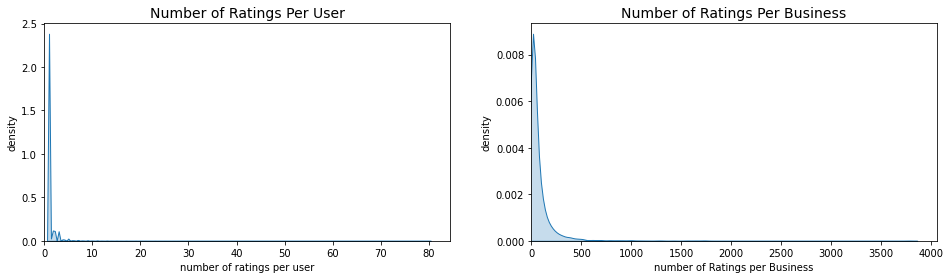

In [59]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_business, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Business", fontsize=14)
plt.xlabel("number of Ratings per Business")
plt.ylabel("density")
plt.show()

In [60]:
from sklearn.neighbors import NearestNeighbors

def find_similar_business(business_id, X, buss_mapper, buss_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        business_id: id of the business of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []

    buss_ind = buss_mapper[business_id]
    buss_vec = X[buss_ind]
    if isinstance(buss_vec, (np.ndarray)):
        buss_vec = buss_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(buss_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(buss_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [61]:
similar_business = find_similar_business('-2bLM6nIETD4Mk-rhjIYZQ', X, buss_mapper, buss_inv_mapper, k=10)
similar_business

KeyError: ignored

In [62]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."


In [63]:
business_names = dict(zip(business['business_id'], business['name']))

business_id = 'oI6phVfv4Vgpsws_1qd5Gg'

similar_business = find_similar_business(business_id, X, buss_mapper, buss_inv_mapper, metric='cosine', k=10)
business_name = business_names[business_id]

print(f"Because you liked {business_name}:")
for i in similar_business:
  print(business_names[i])
lucianos_recs = business[business['business_id'].isin(similar_business)]
lucianos_recs.to_csv(path_or_buf='/content/gdrive/My Drive/SML IW/lucianos_collab.csv', index=False)

KeyError: ignored

In [27]:
business_names = dict(zip(business['business_id'], business['name']))

business_id = 'C96ynw3G1KrqBOdafxbTKw'

similar_business = find_similar_business(business_id, X, buss_mapper, buss_inv_mapper, metric='cosine', k=10)
business_name = business_names[business_id]

print(f"Because you liked {business_name}:")
for i in similar_business:
  print(business_names[i])
subway_recs = business[business['business_id'].isin(similar_business)]
subway_recs.to_csv(path_or_buf='/content/gdrive/My Drive/SML IW/subway_collab.csv', index=False)

Because you liked Subway:
Subway
Clean Juice Trinity
Sunshine Cafe
Firehouse Subs
Burger King
Hungry Howie's Pizza & Subs
Pizza Hut
Hooters
Panda Express


In [64]:
reviews.head()

,user_id,business_id,rating,date,text
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is..."
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,2015-01-04 00:01:03,"Wow! Yummy, different, delicious. Our favo..."
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,2017-01-14 20:54:15,Cute interior and owner (?) gave us tour of up...
5,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,2015-09-23 23:10:31,I am a long term frequent customer of this est...
7,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2015-08-07 02:29:16,Amazingly amazing wings and homemade bleu chee...


In [28]:
business_names = dict(zip(business['business_id'], business['name']))

business_id = 'H0unmI-lJTazbPh-Lt6lBQ'

similar_business = find_similar_business(business_id, X, buss_mapper, buss_inv_mapper, metric='cosine', k=10)
business_name = business_names[business_id]

print(f"Because you liked {business_name}:")
for i in similar_business:
  print(business_names[i])
kungfu_recs = business[business['business_id'].isin(similar_business)]
kungfu_recs.to_csv(path_or_buf='/content/gdrive/My Drive/SML IW/kungfu_collab.csv', index=False)

Because you liked Token Ramen & Kung Fu Tea:
Token Ramen & Kung Fu Tea
Aussie Grill - Brandon
Kung Fu Tea
Cass Street Deli
Izakaya Tori
Jazz Thai Restaurant
Amuni Wood Fired Oven
Sultan Market
Zeko's Mediterranean Grill


## With only restaurants

In [ ]:
business_nona = business.dropna()
print(len(business))
print(len(business_nona))
business_r = business_nona[business_nona.categories.str.contains("Restaurants" or "Food")]
print(len(business_r))
unique_r = business_r.business_id.unique()
r_reviews = reviews[reviews['business_id'].isin(unique_r)]
r_reviews.head(5)

150346
117618
44676


,user_id,business_id,rating,date,text
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is..."
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,2015-01-04 00:01:03,"Wow! Yummy, different, delicious. Our favo..."
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,2017-01-14 20:54:15,Cute interior and owner (?) gave us tour of up...
5,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,2015-09-23 23:10:31,I am a long term frequent customer of this est...
7,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2015-08-07 02:29:16,Amazingly amazing wings and homemade bleu chee...


In [ ]:
r_X, r_user_mapper, r_buss_mapper, r_user_inv_mapper, r_buss_inv_mapper = create_X(r_reviews)

In [ ]:
business_id = 'kxX2SOes4o-D3ZQBkiMRfA'

similar_business = find_similar_business(business_id, r_X, r_buss_mapper, r_buss_inv_mapper, metric='cosine', k=10)
business_name = business_names[business_id]

print(f"Because you liked {business_name}:")
for i in similar_business:
    print(business_names[i])

Because you liked Zaika:
Costa's Pizza & Grill
Taste King Restaurant
Panda Express
Ateethi
Tiffany Diner
Shish-Kabob Palace
Taste Queen Chinese Restaurant
Domino's Pizza
Richman’s Ice Cream & Burger Co.


# KNN Regression

In [51]:
from sklearn.neighbors import KNeighborsRegressor

def find_similar_businesses(business_id, X, train, Y, test, buss_mapper, buss_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        business_id: id of the business of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    # X = X.T
    # neighbour_ids = []

    buss_ind = buss_mapper[business_id]
    buss_vec = X[buss_ind]
    if isinstance(buss_vec, (np.ndarray)):
        buss_vec = buss_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = KNeighborsRegressor(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(train, Y)
    preds = kNN.predict(test)
    print(preds)
    return preds
    # neighbour = kNN.kneighbors(buss_vec, return_distance=False)
    # for i in range(0,k):
    #     n = neighbour.item(i)
    #     neighbour_ids.append(buss_inv_mapper[n])
    # neighbour_ids.pop(0)
    # return neighbour_ids

In [52]:
ratings_train_X = ratings_train[["user_id", "business_id"]]
ratings_train_X
ratings_train_Y = ratings_train[["rating"]]
ratings_train_Y
ratings_test_X = ratings_holdout[["user_id", "business_id"]]
ids = []
for id in ratings_train_X['business_id']:
  ids.append(buss_mapper[id])
ratings_train_X['business_id'] =ids
print(ratings_train_X)

user_ids = []
for id in ratings_train_X['user_id']:
  user_ids.append(user_mapper[id])
ratings_train_X['user_id'] = user_ids
print(ratings_train_X)

ids = []
for id in ratings_test_X['business_id']:
  ids.append(buss_mapper[id])
ratings_test_X['business_id'] =ids
print(ratings_train_X)

user_ids = []
for id in ratings_test_X['user_id']:
  user_ids.append(user_mapper[id])
ratings_test_X['user_id'] = user_ids
print(ratings_train_X)

                       user_id  business_id
4       bcjbaE6dDog4jkNY91ncLQ         2865
13      smOvOajNG0lS4Pq7d8g4JQ         1862
21      WBpQDAZymU0dhIqXcACGNw         4021
24      RreNy--tOmXMl1en0wiBOg         2745
30      Jha0USGDMefGFRLik_xFQg         2653
...                        ...          ...
499915  qZwehAvS51R1AQygzR_9IA         2560
499928  BjOEoHwEWwQCp-csYZDesA         1927
499939  W81s2EdHHq4_CYDJNqhgRg         1107
499940  JB1mt3DX7hIlci3pWzxNjQ         2712
499955  4S6ITbhrxypRMzjfl9-rVA         4170

[60793 rows x 2 columns]
        user_id  business_id
4        139603         2865
13       200351         1862
21       117119         4021
24       101766         2745
30        72952         2653
...         ...          ...
499915   192510         2560
499928    44974         1927
499939   116890         1107
499940    71096         2712
499955    19276         4170

[60793 rows x 2 columns]
        user_id  business_id
4        139603         2865
13       20035

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [66]:

business_id = 'XQfwVwDr-v0ZS3_CbbE5Xw'
knn_start = time.time()
similar_business = find_similar_businesses(business_id, X, ratings_train_X, ratings_train_Y, ratings_test_X, buss_mapper, buss_inv_mapper, metric='manhattan', k=10)
business_name = business_names[business_id]
knn_duration = (time.time() - approach_1_start) * 1.0 / 60 
print('The knn takes {} minutes to run.'.format(knn_duration))

[[4.54545455]
 [3.72727273]
 [3.54545455]
 ...
 [3.81818182]
 [3.36363636]
 [3.72727273]]
The knn takes 73.57375048398971 minutes to run.


In [49]:
mse, mae, r2 = mean_squared_error(ratings_train_Y.rating, similar_business), \
                mean_absolute_error(ratings_train_Y.rating, similar_business), \
                r2_score(ratings_train_Y.rating, similar_business)
print('MSE: {0:.4f}, MAE: {1:.4f}, R2: {2:.4f}'.format(mse, mae, r2))

NameError: ignored

# Content Based - using categories and only restaurants
adapted from: https://www.jillcates.com/pydata-workshop/html/tutorial.html#Step-5:-Item-item-Recommendations-with-k-Nearest-Neighbors

In [10]:
business.shape

(44676, 14)

In [11]:
business_nona = business.dropna()
business_nona.shape

(44676, 14)

In [12]:
business_r = business_nona[business_nona.categories.str.contains("Restaurants" or "Food")]
business_r.head(5)

NameError: ignored

In [6]:
# for s in business_nona.categories:
#   l = s.apply(lambda x: x.split(","))
#   print(l)
business_r = business.copy()
business_r['categories'] = business['categories'].apply(lambda x: x.split(","))
print(business_r['categories'])


3         [Restaurants,  Food,  Bubble Tea,  Coffee & Te...
5         [Burgers,  Fast Food,  Sandwiches,  Food,  Ice...
9         [Ice Cream & Frozen Yogurt,  Fast Food,  Burge...
11          [Vietnamese,  Food,  Restaurants,  Food Trucks]
12        [American (Traditional),  Restaurants,  Diners...
                                ...                        
150325    [Restaurants,  Sandwiches,  Convenience Stores...
150327    [Cafes,  Juice Bars & Smoothies,  Coffee & Tea...
150336                              [Restaurants,  Mexican]
150339    [Restaurants,  Comfort Food,  Food,  Food Truc...
150340                       [Middle Eastern,  Restaurants]
Name: categories, Length: 44676, dtype: object


In [7]:
n_businesses = business_r['business_id'].nunique()
print(f"There are {n_businesses} unique businesses in our business dataset.")


There are 44676 unique businesses in our business dataset.


In [8]:
categories = set(c for C in business_r['categories'] for c in C)

for c in categories:
    business[c] = business_r.categories.transform(lambda x: int(c in x))

business_cats = business_r.drop(columns=['business_id', 'name','categories', 'attributes'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


In [9]:
business_cats = business_cats.drop(columns=['city', 'state','postal_code', 'latitude', 'longitude', 'hours'])
business_cats = business_cats.drop(columns=['address'])

In [10]:
business_cats.columns
len(business_cats)

44676

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(business_cats, business_cats)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (44676, 44676)


In [16]:
def business_finder(title):
    return business[business['name'].str.contains(title)]['name'].tolist()

business_finder('Wawa')

['Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 'Wawa',
 

In [13]:
business_r.reset_index(inplace=True)
business_cats.reset_index(inplace=True)
print(business_r.index)
print(business_r.shape)

RangeIndex(start=0, stop=44676, step=1)
(44676, 15)


In [38]:
bus_idx = dict(zip(business_r['name'], list(business_r.index)))
name = business_finder('pizza')[0]
n_recommendations = 10

idx = bus_idx[name]
print(idx)
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_businesses = [i[0] for i in sim_scores]

print(f"Recommendations for {name}:")
print(business.iloc[idx])
lucianos_recs = business.iloc[similar_businesses]

4977
Recommendations for Luciano’s pizza:
business_id              oI6phVfv4Vgpsws_1qd5Gg
name                            Luciano’s pizza
address                       363 W Browning Rd
city                                   Bellmawr
state                                        NJ
                                  ...          
 Amateur Sports Teams                         0
 Waffles                                      0
 Malaysian                                    0
Tacos                                         0
 Education                                    0
Name: 16730, Length: 1094, dtype: object


In [39]:
bus_idx = dict(zip(business_r['name'], list(business_r.index)))
name = business_finder('Subway')[0]
n_recommendations = 10

idx = bus_idx[name]
print(idx)
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_businesses = [i[0] for i in sim_scores]

print(f"Recommendations for {name}:")
print(business.iloc[idx])
subway_recs = business.iloc[similar_businesses]

44645
Recommendations for Subway:
business_id                 C96ynw3G1KrqBOdafxbTKw
name                                        Subway
address                  4882 Sun City Center Blvd
city                               Sun City Center
state                                           FL
                                   ...            
 Amateur Sports Teams                            0
 Waffles                                         0
 Malaysian                                       0
Tacos                                            0
 Education                                       0
Name: 150231, Length: 1094, dtype: object


In [40]:
subway_recs

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Party Equipment Rentals,Boat Repair,Arabic,Izakaya,Irish,Amateur Sports Teams,Waffles,Malaysian,Tacos,Education
1835,aYMpjij5ShtEoZueMrQPRw,The Mill,406 E Haley St,Santa Barbara,CA,93101,34.421119,-119.690633,4.0,5,...,0,0,0,0,0,0,0,0,0,0
2294,agTcS5LYZJe4gNiXK6nNkw,Buca D’Oro,711 Locust St,Philadelphia,PA,19106,39.947077,-75.154166,4.0,5,...,0,0,0,0,0,0,0,0,0,0
3025,uAbUh-mivr8AFoEbk-gANA,XT Munchies,5705 N Nebraska Ave,Tampa,FL,33604,27.999241,-82.450863,4.0,5,...,0,0,0,0,0,0,0,0,0,0
4007,z3Zv5di2BEok__snpopeBA,Largo Golf Course,12500 Vonn Rd,Largo,FL,33774,27.886865,-82.820953,4.0,5,...,0,0,0,0,0,0,0,0,0,0
5427,WM5oG8uHlAnjcSvl-HArrQ,Little Road Farm Stand,3533 Little Rd,New Port Richey,FL,34655,28.209354,-82.666265,4.0,5,...,0,0,0,0,0,0,0,0,0,0
6203,zgaaJ6jAhKpWCtQRryJfVQ,Devito's Pizza IV,124 Tremont St,Trenton,NJ,08611,40.203748,-74.750269,4.0,5,...,0,0,0,0,0,0,0,0,0,0
6502,IcWtPNZIQCybqoDMpvQzjg,Thai 5 Fast Food,"13220 S Belcher Rd, Ste 19",Largo,FL,33773,27.893130,-82.746640,4.0,5,...,0,0,0,0,0,0,0,0,0,0
6721,lqbhT7Am0c0iHkkitbI6Gg,Kased Brothers Halal,3645 Florida Ave,Kenner,LA,70065,30.023238,-90.240518,4.0,5,...,0,0,0,0,0,0,0,0,0,0
6800,EMIRaHf4ngpJ2qYdl_eChw,Nancy's Original,17420 U S 41,Lutz,FL,33549,28.123537,-82.463384,4.0,5,...,0,0,0,0,0,0,0,0,0,0
6984,V9MTs8xqnY-xloFZXDBzqQ,El Rey International Restaurant,3107 Lafayette Rd,Indianapolis,IN,46222,39.811238,-86.221563,4.0,5,...,0,0,0,0,0,0,0,0,0,0


In [41]:
bus_idx = dict(zip(business_r['name'], list(business_r.index)))
name = business_finder('Kung Fu Tea')[0]
n_recommendations = 10

idx = bus_idx[name]
print(idx)
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_businesses = [i[0] for i in sim_scores]

print(f"Recommendations for {name}:")
print(business.iloc[idx])
kungfu_recs = business.iloc[similar_businesses]

42497
Recommendations for Token Ramen & Kung Fu Tea:
business_id                 H0unmI-lJTazbPh-Lt6lBQ
name                     Token Ramen & Kung Fu Tea
address                       401 S Dale Mabry Hwy
city                                         Tampa
state                                           FL
                                   ...            
 Amateur Sports Teams                            0
 Waffles                                         0
 Malaysian                                       0
Tacos                                            0
 Education                                       0
Name: 143152, Length: 1094, dtype: object


In [42]:
kungfu_recs

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Party Equipment Rentals,Boat Repair,Arabic,Izakaya,Irish,Amateur Sports Teams,Waffles,Malaysian,Tacos,Education
10409,P48O-s2OOVq8UBtskQ90tQ,Uncle Ed's Restaurant,4824 118 Avenue NW,Edmonton,AB,T5W 1B4,53.570634,-113.416455,4.0,60,...,0,0,0,0,0,0,0,0,0,0
20031,3VKYbajPpszKNFv32ey2dA,Dam Good Cafe,161 N Main St,Dublin,PA,18917,40.392058,-75.236224,4.0,60,...,0,0,0,0,0,0,0,0,0,0
25489,eZ8O81EtzTs3-Z_QuqgiVQ,Blitz Bar & Grill,400 S Rock Blvd,Sparks,NV,89431,39.530368,-119.766055,4.0,60,...,0,0,0,0,0,0,0,0,0,0
28986,gjSygHjeDCDCPsCdFiyW3Q,Heelok Chinese Restaurant,"1613 Rt 38, Ste 6",Lumberton,NJ,08048,39.982963,-74.790403,4.0,60,...,0,0,0,0,0,0,0,0,0,0
34100,AglkyqtcY_NHlaZHYGJRRQ,Falafel N Cafe,24139 US Hwy 19 N,Clearwater,FL,33763,27.991327,-82.727930,4.0,60,...,0,0,0,0,0,0,0,0,0,0
43307,H9Qk48EFNBwFiRd7bw-K4A,Orchid Asian Fusion,3025 Rt 130,Delran,NJ,08075,40.012500,-74.962300,4.0,60,...,0,0,0,0,0,0,0,0,0,0
48001,bUL0ccO-bbQICKHImPUyJQ,JOEY Bell Tower,10310 101 Street,Edmonton,AB,T5J 4X1,53.544876,-113.494209,4.0,60,...,0,0,0,0,0,0,0,0,0,0
49468,5RXDgXZWajY_cPWKbOGqKQ,2nd Street Bagels,496 2nd St Pike,Southampton,PA,18966,40.169909,-75.046301,4.0,60,...,0,0,0,0,0,0,0,0,0,0
49795,XuO9tZt0mEJeawrrt0R52g,Pub Webb,1527 Cecil B Moore Ave,Philadelphia,PA,19121,39.979135,-75.160534,4.0,60,...,0,0,0,0,0,0,0,0,0,0
51404,yID8zq7b4YRcWn5Vcc-MuA,Pho Kang,2135 St Charles Ave,New Orleans,LA,70130,29.934495,-90.080586,4.0,60,...,0,0,0,0,0,0,0,0,0,0


In [43]:
lucianos_recs.to_csv(path_or_buf='/content/gdrive/My Drive/SML IW/lucianos_content.csv', index=False)

In [44]:
subway_recs.to_csv(path_or_buf='/content/gdrive/My Drive/SML IW/subway_content.csv', index=False)

In [45]:
kungfu_recs.to_csv(path_or_buf='/content/gdrive/My Drive/SML IW/kungfu_content.csv', index=False)